In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import pandas as pd
import cudf as gd
from cuml.manifold.umap import UMAP as cumlUMAP
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
window_loc = DATA_DIR / 'umap_windows/buckeye/way_say_day_5.pickle'

In [5]:
words_df = pd.read_pickle(window_loc)

In [6]:
words_df[:3]

start_time    end_time word   phones            phone_start_times  \
445  236.236188  236.352105  say  [s, eh]  [0.0, 0.060875000000010004]   
492  250.321120  250.586825  say  [s, ey]    [0.0, 0.1448169999999891]   
610  293.978018  294.234862  say  [s, ey]   [0.0, 0.13373199999995222]   

                                 phone_end_times  utterance_number  \
445  [0.060875000000010004, 0.11591699999999605]                74   
492    [0.1448169999999891, 0.26570499999999697]                17   
610   [0.13373199999995222, 0.25684400000000096]                22   

     position_in_utterance  word_number indv  indvi age sex     key   rate  \
445                     31           31  s25      0   o   f  s2501b  16000   
492                     10           10  s25      0   o   f  s2501b  16000   
610                      9            9  s25      0   o   f  s2501b  16000   

                                           spectrogram  \
445  [[0, 0, 0, 1, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0,...   
492  [[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
610  [[146, 146, 145, 144, 143, 141, 138, 134, 130,...   

                                               windows  
445  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1...  
492  [[[1, 0, 20, 43, 30, 3, 0, 0, 0, 0, 0, 0, 2, 2...  
610  [[[146, 108, 68, 121, 120, 92, 70, 72, 79, 88,...

In [22]:
np.unique(np.concatenate(words_df.phones.values))

array(['ah', 'ay', 'd', 'dh', 'dx', 'eh', 'ey', 'ih', 'iy', 'm', 'n', 's',
       't', 'th', 'tq', 'w', 'y', 'z'], dtype='<U2')

In [7]:
n_windows = [len(row.windows) for idx, row in words_df.iterrows()]
words = np.concatenate([np.repeat(row.word, len(row.windows)) for idx, row in words_df.iterrows()])

In [8]:
words[:10]

array(['say', 'say', 'say', 'say', 'say', 'say', 'say', 'say', 'say',
       'say'], dtype='<U3')

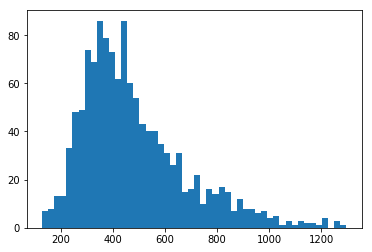

In [9]:
plt.hist(n_windows, bins=50);

In [10]:
rate = 16000

In [11]:
windows = np.vstack(list(words_df.windows))
print(np.shape(windows))
windows = np.reshape(windows, (len(windows), np.prod(np.shape(windows)[1:])))
print(np.shape(windows))

(607214, 10, 32)
(607214, 320)


In [12]:
cuml_umap = cumlUMAP()# min_dist = 0.5
embedding = cuml_umap.fit_transform(windows)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  


(-15, 15)

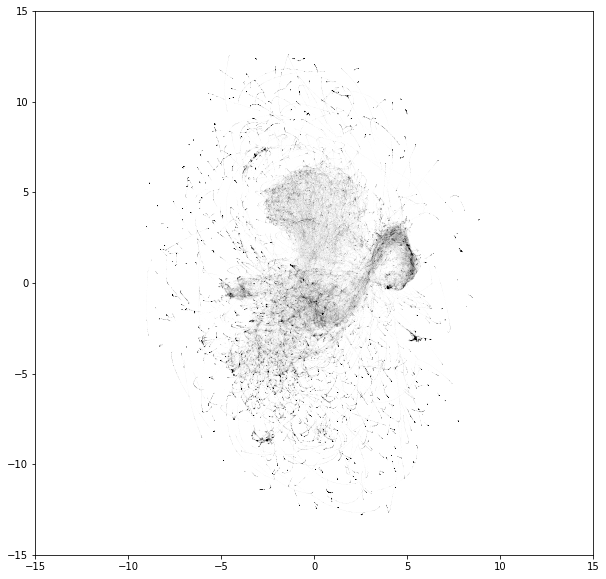

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.0025, s = 1, color='k')
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

In [14]:
len(np.unique(words))

3

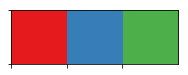

In [15]:
pal = sns.color_palette('Set1', len(np.unique(words)))
sns.palplot(pal)
word_pal = {word:pal[wordi] for wordi, word in enumerate(np.unique(words))}

In [16]:
word_pal

{'day': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 'say': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 'way': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726)}

In [17]:
cols = [word_pal[i] for i in words]

(-15, 15)

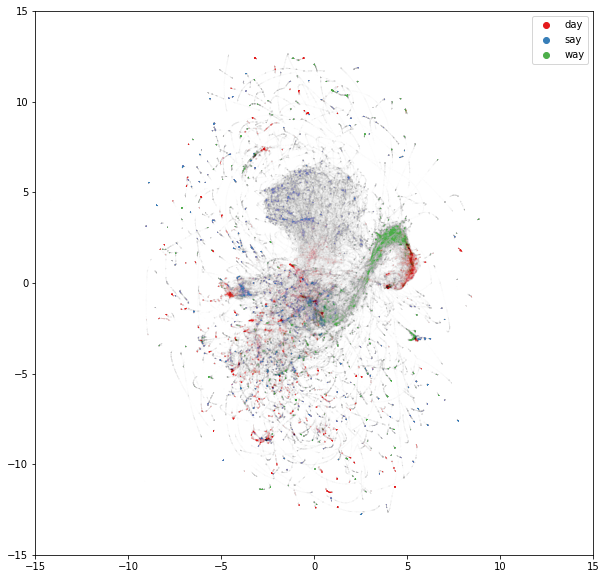

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)

ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.0025, s = 1, color=cols)
ax.set_xlim([-15,15])
ax.set_ylim([-15,15])

(-10, 10)

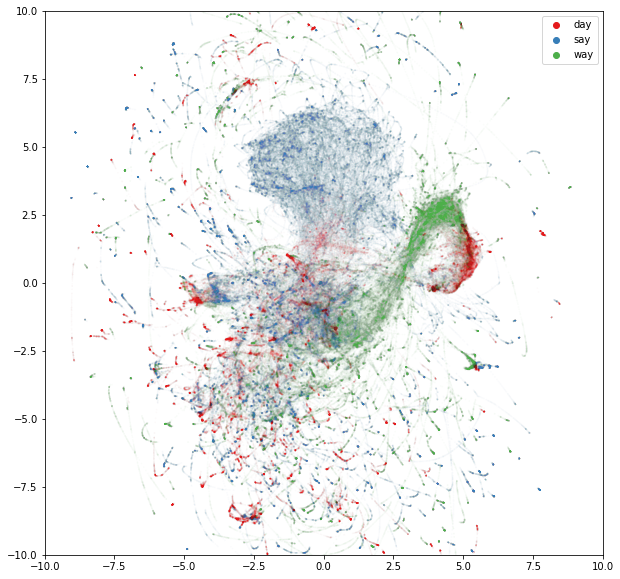

In [20]:
fig, ax = plt.subplots(figsize=(20,20))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)

ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.01, s = 1, color=cols)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])

(-10, 10)

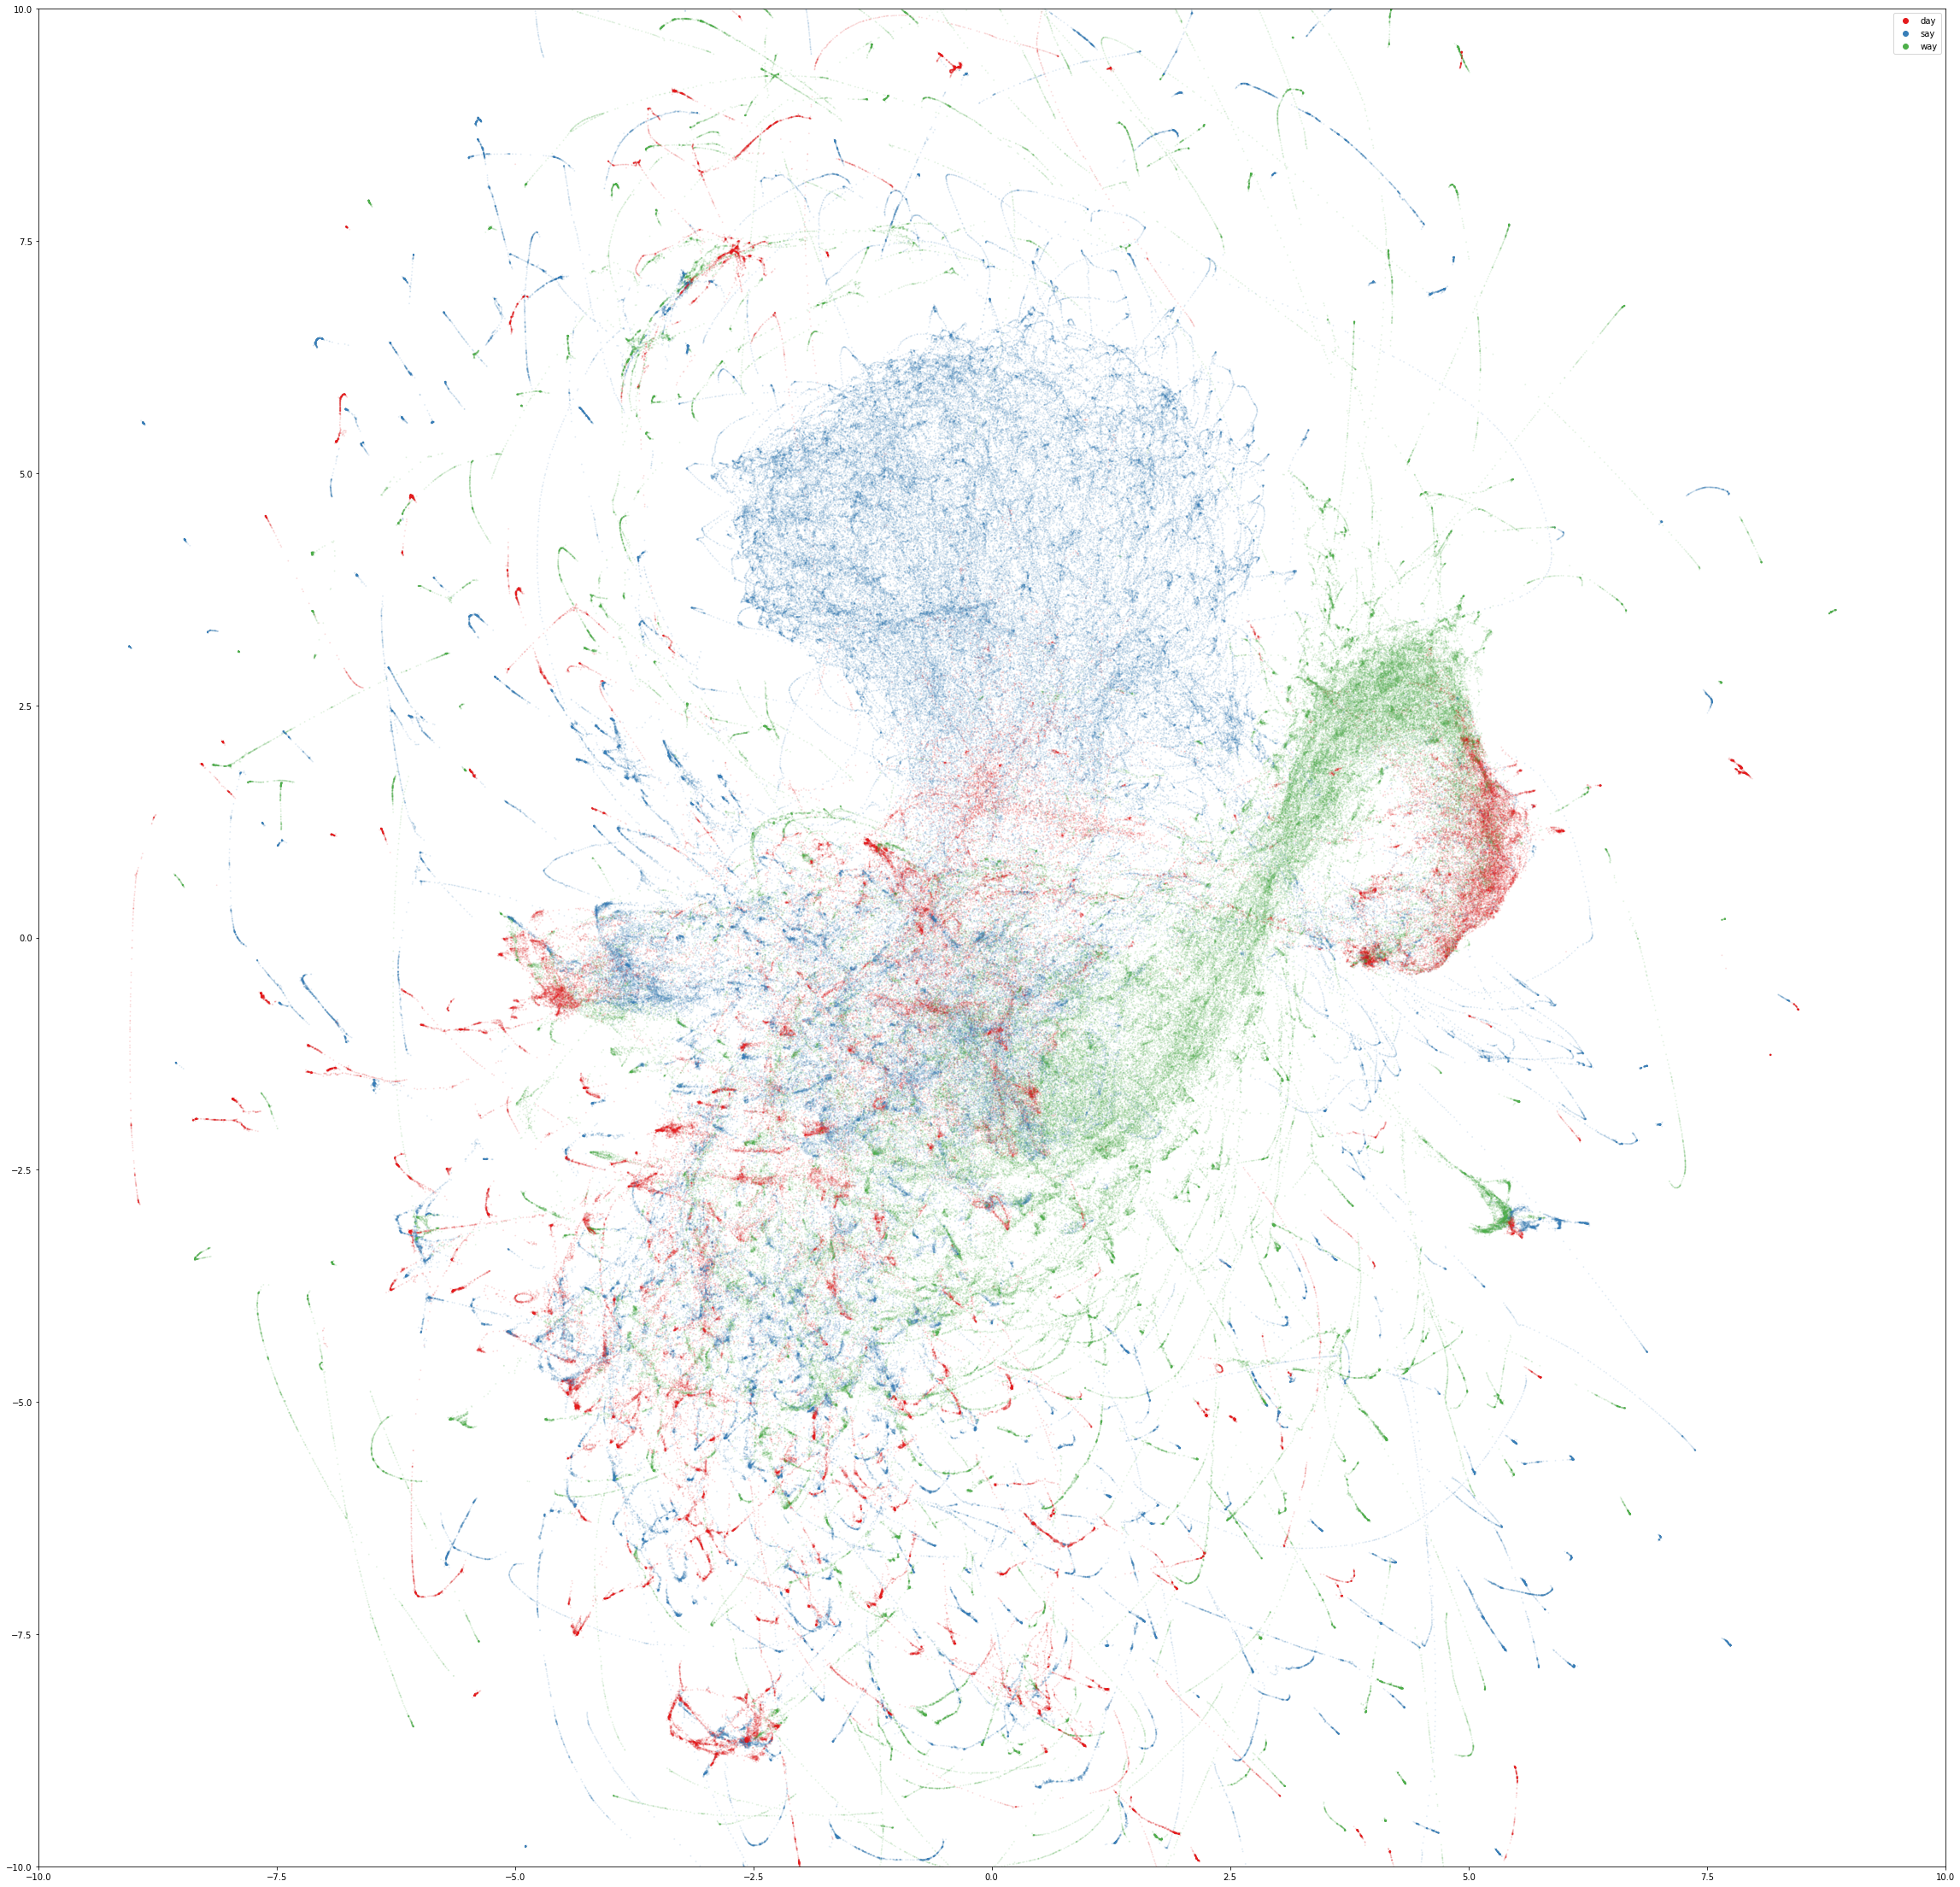

In [24]:
fig, ax = plt.subplots(figsize=(40,40))
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in word_pal.values()]
ax.legend(markers, word_pal.keys(), numpoints=1)

ax.scatter(embedding[:,0], embedding[:,1], alpha = 0.1, s = 1, color=cols)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])